# 3D 2nd-order acoustic parabola

In this notebook, a basic 3D immersed boundary is implemented.

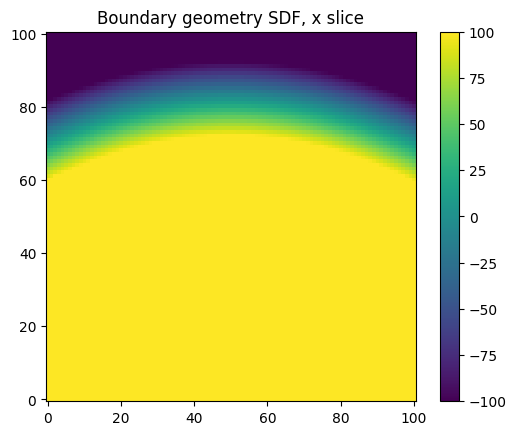

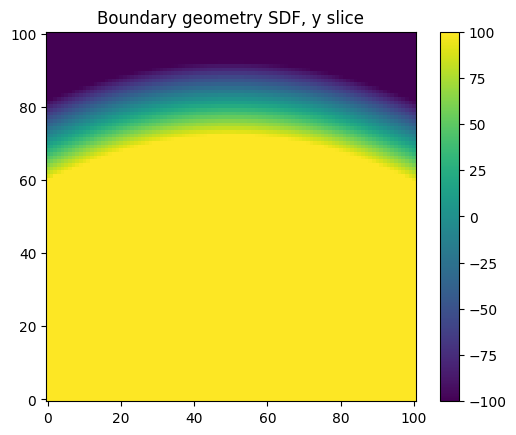

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sdf
sdf = read_sdf('parabola', 3)

midx = sdf.shape[0]//2
midy = sdf.shape[1]//2

plt.imshow(sdf.data[midx, :].T, origin='lower')
plt.title("Boundary geometry SDF, x slice")
plt.colorbar()
plt.show()

plt.imshow(sdf.data[:, midy].T, origin='lower')
plt.title("Boundary geometry SDF, y slice")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2+p.dy2+p.dz2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + p.dy4 + p.dz4 + 2*p.dx2dy2 + 2*p.dx2dz2 + 2*p.dy2dz2, 0)]  # Zero biharmonic

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [ ]:
derivs = (p.dx2, p.dy2, p.dz2)
subs = boundary.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y, z), (x, 2))
Generating stencils for Derivative(p(t, x, y, z), (y, 2))


In [ ]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 600.  # Simulation last 0.6 seconds (600 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.
src.coordinates.data[0, 2] = 500.

In [ ]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(subs[p.dx2]+subs[p.dy2]+subs[p.dz2]))

In [ ]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

In [ ]:
op = dv.Operator([eq] + src_term)
op(time=time_range.num-1, dt=dt)

In [ ]:
plt.imshow(p.data[1, midx].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

plt.imshow(p.data[1, :, midy].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [ ]:
np.linalg.norm(p.data)